data normalization ok
batch normalization ok
momentum learning rate ok
learning rate decay ok
weight initialize ok
dropout ok
weight regularization ok


early stopping
weight pruning
grid search
focal loss
penalty

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [3]:
data = pd.read_csv("dataset/preprocessed.csv")

In [4]:
data = data.drop(data[data.target == -1].index)
data.shape

(762094, 44)

In [5]:
# Separate input features and target
targets = data.target
targets -= 1


In [6]:
targets = targets.to_numpy()

In [7]:
features = data.drop('target', axis=1)

In [8]:
features = features.to_numpy()

In [9]:
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 0)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)

In [11]:
X_train.shape

(487740, 43)

In [12]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 50166  55949  87609 117459 176557]]


Text(0.5, 1.0, 'Unbalanced Data Distribution')

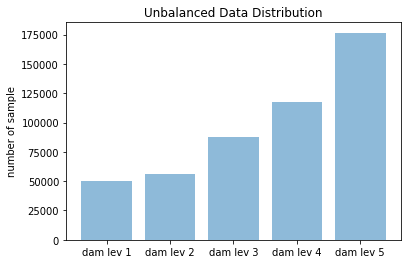

In [13]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Unbalanced Data Distribution')

In [14]:
sm = SMOTETomek(random_state = 27, n_jobs = -1)

X_train, y_train = sm.fit_sample(X_train, y_train)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [15]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [162635 155765 149211 144863 147975]]


Text(0.5, 1.0, 'After Re-sampling Data Distribution')

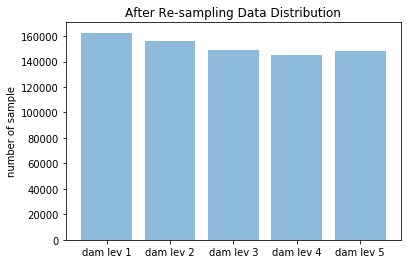

In [16]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('After Re-sampling Data Distribution')

In [17]:
print((X_train ).shape)
print(( y_train).shape)


(760449, 43)
(760449,)


In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)


/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = torch.from_numpy(class_weights)
class_weights



tensor([0.9352, 0.9764, 1.0193, 1.0499, 1.0278], dtype=torch.float64)

In [20]:
batch_size = 100
epochs = 10
input_dim = 43
output_dim = 5
lr_rate = 0.1
momentum_val = 0.9
weight_decay_val = 0.0001
gamma_val = 0.5
prob = 0.2

In [21]:
class datasetLoad(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [22]:
X_train = datasetLoad(X_train, y_train)
X_val = datasetLoad(X_val, y_val)

In [23]:
train_loader = torch.utils.data.DataLoader(dataset = X_train, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = X_val, batch_size = batch_size, shuffle=True)

In [24]:
import torch.nn as nn
import torch.nn.functional as F
class neuralNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim, dropout_p):
        super(neuralNetwork, self).__init__()
        
        # self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        self.hidden1 = nn.Linear(input_dim, hidden1_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden1.weight)
        self.bnhidden1 = nn.BatchNorm1d(hidden1_dim)
        
        # self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden2.weight)
        self.bnhidden2 = nn.BatchNorm1d(hidden2_dim)
        
        # self.hidden3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.hidden3 = nn.Linear(hidden2_dim, hidden3_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden3.weight)
        self.bnhidden3 = nn.BatchNorm1d(hidden3_dim)
        
        # self.output = nn.Linear(hidden3_dim, output_dim)
        self.output = nn.Linear(hidden3_dim, output_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.output.weight)

        self.dropout = nn.Dropout(dropout_p)
    def forward(self, x):
        
        x = self.hidden1(x)   
        x = self.dropout(x)
        x = self.bnhidden1(x)        
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        x = self.hidden2(x)        
        x = self.dropout(x)
        x = self.bnhidden2(x)
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        x = self.hidden3(x)
        x = self.dropout(x)
        x = self.bnhidden3(x)
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        outputs = self.output(x)
        return outputs

In [25]:
model = neuralNetwork(input_dim, 20,20, 20, output_dim, prob)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [26]:
criterion = torch.nn.CrossEntropyLoss(weight = class_weights.float())

In [27]:
from torch.optim.lr_scheduler import MultiStepLR

optimizer = torch.optim.SGD(model.parameters(), lr = lr_rate, momentum = momentum_val, weight_decay = weight_decay_val)


scheduler = MultiStepLR(optimizer, milestones=[2,4,6,8], gamma = gamma_val)

In [28]:


import datetime
a = datetime.datetime.now().replace(microsecond=0)
train_loss = []
validation_loss = []
for epoch in range(epochs):
    train_loss_val = 0.0
    num_of_train_iter = 0
    for i, (features, labels) in enumerate(train_loader):
        features = Variable(features)
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(features.float())
        loss = criterion(outputs.float(), labels)
        loss.backward()
        optimizer.step()
        train_loss_val += loss.item()
        num_of_train_iter = i
    train_loss_val /= num_of_train_iter
    
    validation_loss_val = 0.0
    num_of_val_iter = 0
        
    # calculate Accuracy
    correct = 0.0
    total = 0
    accuracy = 0.0
    for i, (features, labels) in enumerate( val_loader):
        features = Variable(features)
        with torch.no_grad():
            outputs = model(features.float())
        loss = criterion(outputs.float(), labels)
        validation_loss_val += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
        accuracy += 100 * correct/total
        num_of_val_iter = i
    validation_loss_val /= num_of_val_iter
    accuracy /=  num_of_val_iter
    
    scheduler.step()
     
    
    train_loss.append(train_loss_val)
    validation_loss.append(validation_loss_val)
    # if(epoch % 5 == 0):
    #     print("{")
    #     print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
    #     print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
    #     print("}")
    print("{")
    print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
    print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
    print("}")

{
Epoch: 0. Train Loss: 1.3378846354700276. 
Epoch: 0. Validation Loss: 1.4188624674223602. Validation Accuracy: 38.14468002319336.
}
{
Epoch: 1. Train Loss: 1.3216646087288795. 
Epoch: 1. Validation Loss: 1.4655621403842016. Validation Accuracy: 36.12254333496094.
}
{
Epoch: 2. Train Loss: 1.3087178591926871. 
Epoch: 2. Validation Loss: 1.491605982025497. Validation Accuracy: 36.15273666381836.
}
{
Epoch: 3. Train Loss: 1.308799810280366. 
Epoch: 3. Validation Loss: 1.4831556554110545. Validation Accuracy: 36.474517822265625.
}
{
Epoch: 4. Train Loss: 1.3002594243940837. 
Epoch: 4. Validation Loss: 1.472440216852271. Validation Accuracy: 37.302650451660156.
}
{
Epoch: 5. Train Loss: 1.3008200361313536. 
Epoch: 5. Validation Loss: 1.4192613684026016. Validation Accuracy: 39.24367904663086.
}
{
Epoch: 6. Train Loss: 1.295270275091385. 
Epoch: 6. Validation Loss: 1.490360823002284. Validation Accuracy: 36.02473831176758.
}
{
Epoch: 7. Train Loss: 1.2951601740249141. 
Epoch: 7. Validation

In [29]:
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

0:03:20


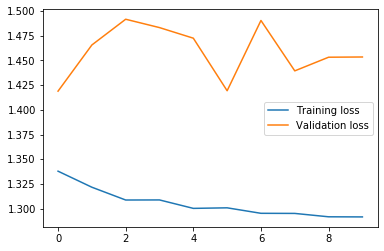

In [30]:
# plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()

In [31]:
with torch.no_grad():
    outputs = model(torch.from_numpy(X_test).float())
_, predicted = torch.max(outputs.data, 1)


In [32]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(predicted,y_test)
accuracy*100

37.89422578549918

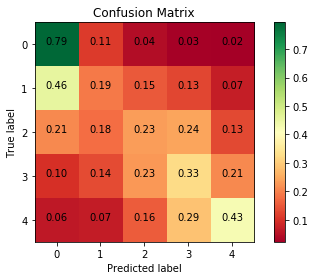

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
plt.show()



